<a href="https://colab.research.google.com/github/rontalapoojareddy/DeepLearning1/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2503B05130 M.tech(CSE)**

**Rontala Pooja Reddy**

**Set Up Environment**

In [ ]:
pip install torch torchvision matplotlib numpy


**Imports and Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


**Load Data**

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.02MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.01MB/s]


**Encoder Network**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


**Reparameterization Trick (SGVB Estimator)**

In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


**Decoder Network**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon


**VAE Model**

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


**ELBO Loss**

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div


**Train the VAE Model**

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss / len(train_dataset):.4f}")


Epoch [1/20] Loss: 164.7378
Epoch [2/20] Loss: 121.4918
Epoch [3/20] Loss: 114.5349
Epoch [4/20] Loss: 111.6152
Epoch [5/20] Loss: 109.8870
Epoch [6/20] Loss: 108.7464
Epoch [7/20] Loss: 107.8793
Epoch [8/20] Loss: 107.2059
Epoch [9/20] Loss: 106.7077
Epoch [10/20] Loss: 106.2604
Epoch [11/20] Loss: 105.8921
Epoch [12/20] Loss: 105.6005
Epoch [13/20] Loss: 105.2824
Epoch [14/20] Loss: 105.0735
Epoch [15/20] Loss: 104.8668
Epoch [16/20] Loss: 104.6504
Epoch [17/20] Loss: 104.4796
Epoch [18/20] Loss: 104.3388
Epoch [19/20] Loss: 104.1468
Epoch [20/20] Loss: 103.9951


**Generate New Images**

In [ ]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = model.decoder(z).cpu()


**Generate New Images**

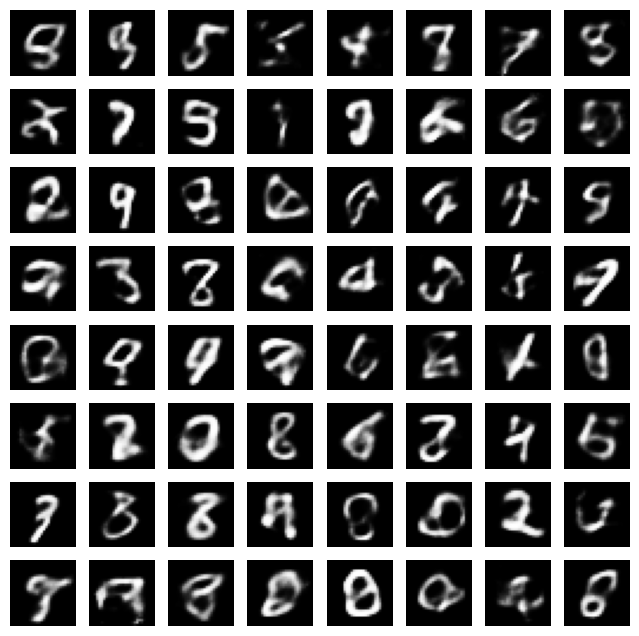

In [ ]:
# Plot generated samples
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].view(28, 28), cmap='gray')
    ax.axis('off')
plt.show()


**Reconstructed Images**

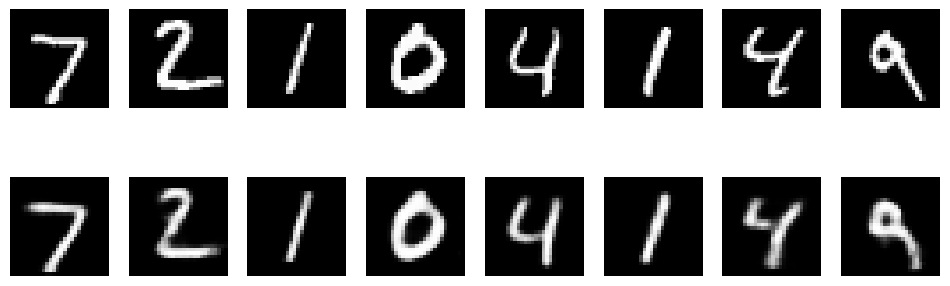

In [ ]:
data, _ = next(iter(test_loader))
data = data.view(-1, 784).to(device)

with torch.no_grad():
    recon, _, _ = model(data)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), "vae_mnist.pth")
